<a href="https://colab.research.google.com/github/feiduobaby/good-first-issue/blob/main/Midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Import Data

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions files -c jane-street-real-time-market-data-forecasting

In [ ]:
pip install kaggle==1.5.12

In [ ]:
cd ../partition_id=3/

/content/train.parquet/partition_id=3


In [ ]:
!kaggle competitions download -c jane-street-real-time-market-data-forecasting -f train.parquet/partition_id=3/part-0.parquet

100% 999M/0.98G [00:07<00:00, 155MB/s]
100% 0.98G/0.98G [00:07<00:00, 133MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!cp -r /content/drive/MyDrive/janestreet /content/

2. EDA

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
PATH = '/content/janestreet'

features = pd.read_csv(f'{PATH}/features.csv')
train_feat = pd.read_parquet(f'{PATH}/train.parquet/partition_id=1/part-0.parquet')
test_feat = pd.read_parquet(f'{PATH}/test.parquet/date_id=0/part-0.parquet')

In [ ]:
print(features.isnull().values.any())
print(train_feat.isnull().sum()[train_feat.isnull().sum() > 0])
print(test_feat.isnull().sum()[test_feat.isnull().sum() > 0])

False
feature_00    1237842
feature_01    1237842
feature_02    1237842
feature_03    1237842
feature_04    1237842
feature_15      79289
feature_16         41
feature_17      13267
feature_18         29
feature_19         29
feature_21    2804247
feature_26    2804247
feature_27    2804247
feature_31    2804247
feature_32      31455
feature_33      31455
feature_39     432555
feature_40      14839
feature_41     102456
feature_42     432555
feature_43      14839
feature_44     102456
feature_45      90060
feature_46      90060
feature_50     422784
feature_51       3303
feature_52      92484
feature_53     422784
feature_54       3303
feature_55      92484
feature_56         29
feature_57         29
feature_58      31455
feature_62      81824
feature_63      63159
feature_64      66018
feature_65      90060
feature_66      90060
feature_73      31455
feature_74      31455
feature_75         46
feature_76         46
dtype: int64
feature_15    39
feature_17    39
feature_21     1
featur

In [ ]:
features.head(2)

,feature,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16
0,feature_00,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True
1,feature_01,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,True


In [ ]:
train_feat.head(2)

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,170,0,0,2.112212,NaN,NaN,NaN,NaN,NaN,1.060330,...,-0.421823,-0.293646,-0.061842,-0.305413,-0.419151,-0.111796,-0.535104,-0.044332,-0.039061,-0.744789
1,170,0,1,2.760715,NaN,NaN,NaN,NaN,NaN,0.482468,...,3.111076,-0.075267,-0.359360,-1.270054,-0.018332,-0.040286,-1.417509,0.085840,0.487232,-0.124533


In [ ]:
test_feat.head(2)

,row_id,date_id,time_id,symbol_id,weight,is_scored,feature_00,feature_01,feature_02,feature_03,...,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,0,0,0,0,3.169998,False,0.0,0.0,0.0,0.0,...,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
1,1,0,0,1,2.165993,False,0.0,-0.0,0.0,0.0,...,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0


<Axes: >

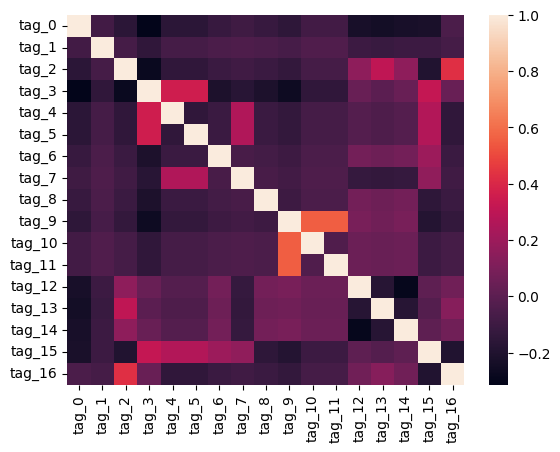

In [ ]:
sns.heatmap(features.set_index('feature').corr())

<Axes: ylabel='Frequency'>

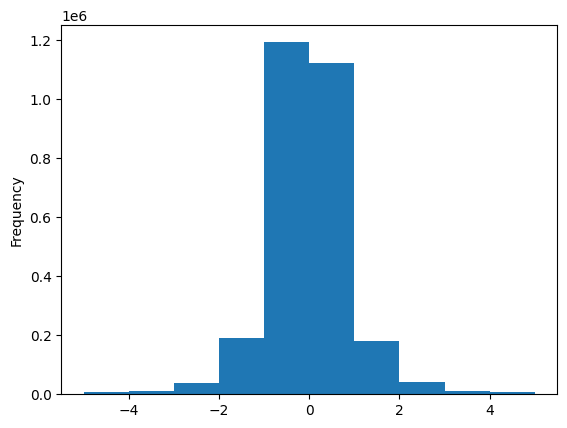

In [ ]:
train_feat['responder_6'].plot(kind='hist')

In [ ]:
train_feat.isnull().mean()

,0
date_id,0.000000
time_id,0.000000
symbol_id,0.000000
weight,0.000000
feature_00,0.441417
...,...
responder_4,0.000000
responder_5,0.000000
responder_6,0.000000
responder_7,0.000000


<Axes: >

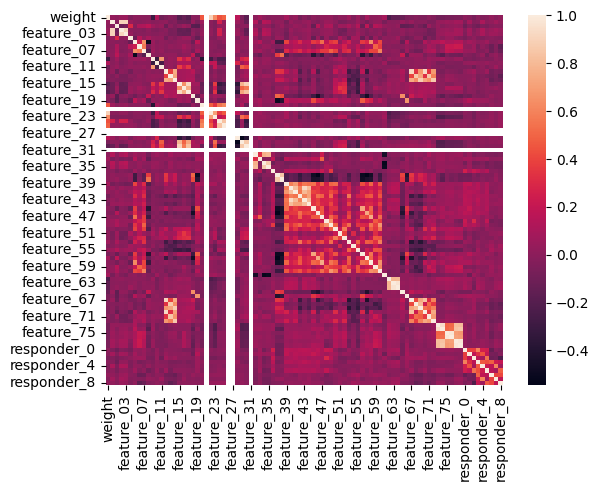

In [ ]:
sns.heatmap(train_feat.sample(1000).iloc[:, 3:].corr())

<Axes: >

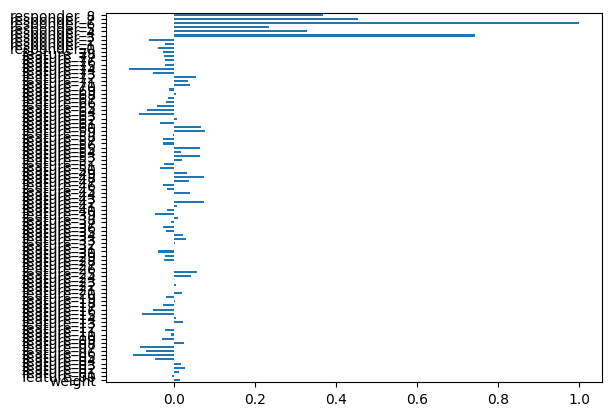

In [ ]:
train_feat.sample(1000).iloc[:, 3:].corr().responder_6.plot(kind='barh')

3. XGBoost Baseline

In [2]:
import os
import joblib
import polars as pl
import xgboost as xgb
import numpy as np
import pandas as pd

In [3]:
# Paths and constants
input_path = '/content/janestreet'
def read_selected_data(input_path):
    # Define the directory containing your data files

    # List three specific Parquet files you want to read
    selected_files = [f"partition_id={i}/part-0.parquet" for i in range(1)]
    # Load and filter the data from only the selected Parquet files
    dfs = []
    for file_name in selected_files:
        file_path = f'{input_path}/train.parquet/{file_name}'
        lazy_df = pl.scan_parquet(file_path)
        df = lazy_df.collect()
        dfs.append(df)

    # Concatenate all dataframes into a single dataframe
    full_df = pl.concat(dfs)

    return full_df

In [4]:
df = read_selected_data(input_path)
df = df.fill_null(strategy='forward')

# Prepare feature names
feature_names = [f"feature_{i:02d}" for i in range(79)]

# Prepare training and validation data
num_valid_dates = 100
dates = df['date_id'].unique().to_numpy()
valid_dates = dates[-num_valid_dates:]
train_dates = dates[:-num_valid_dates]

In [22]:
# Extract features, target, and weights for validation and training sets
X_valid = df.filter(pl.col('date_id').is_in(valid_dates)).select(feature_names).fill_null(0).to_numpy()
y_valid = df.filter(pl.col('date_id').is_in(valid_dates)).select('responder_6').fill_null(0).to_numpy().ravel()
w_valid = df.filter(pl.col('date_id').is_in(valid_dates)).select('weight').fill_null(0).to_numpy().ravel()

X_train = df.filter(pl.col('date_id').is_in(train_dates)).select(feature_names).fill_null(0).to_numpy()
y_train = df.filter(pl.col('date_id').is_in(train_dates)).select('responder_6').fill_null(0).to_numpy().ravel()
w_train = df.filter(pl.col('date_id').is_in(train_dates)).select('weight').fill_null(0).to_numpy().ravel()

In [7]:
def r2_xgb(y_true, y_pred, sample_weight=None):
    if sample_weight is None:
        sample_weight = np.ones_like(y_true)
    r2 = 1 - np.average((y_pred - y_true) ** 2, weights=sample_weight) / (np.average((y_true) ** 2, weights=sample_weight) + 1e-38)
    return -r2

In [8]:
# Train the XGBoost model
model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.1,
    max_depth=6,
    tree_method='hist',
#     device="cuda",
    objective='reg:squarederror',
    eval_metric=r2_xgb,
    disable_default_eval_metric=True,
    early_stopping_rounds=2
)

In [9]:
model.fit(
    X_train, y_train,
    sample_weight=w_train,
    eval_set=[(X_valid, y_valid)],
    sample_weight_eval_set=[w_valid],
    verbose=2)

[0]	validation_0-r2_xgb:-0.00187
[2]	validation_0-r2_xgb:-0.00487
[4]	validation_0-r2_xgb:-0.00654
[6]	validation_0-r2_xgb:-0.00753
[8]	validation_0-r2_xgb:-0.00888
[10]	validation_0-r2_xgb:-0.00987
[12]	validation_0-r2_xgb:-0.01029
[14]	validation_0-r2_xgb:-0.01062
[16]	validation_0-r2_xgb:-0.01103
[18]	validation_0-r2_xgb:-0.01139
[20]	validation_0-r2_xgb:-0.01147
[22]	validation_0-r2_xgb:-0.01168
[23]	validation_0-r2_xgb:-0.01044


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None,
             disable_default_eval_metric=True, early_stopping_rounds=2,
             enable_categorical=False,
             eval_metric=<function r2_xgb at 0x77fef6996480>,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None, ...)

In [10]:
if not os.path.exists("./model_save"):
    # Create the directory if it does not exist
    os.mkdir("./model_save")
model.save_model('./model_save/xgboost_model_baseline.json')

In [11]:
model_loaded = xgb.XGBRegressor()
model_loaded.load_model('/content/model_save/xgboost_model_baseline.json')

In [12]:
test = pl.scan_parquet("/content/janestreet/test.parquet/date_id=0/part-0.parquet")
test = test.collect()
test = test.to_pandas()

In [13]:
test.head()

,row_id,date_id,time_id,symbol_id,weight,is_scored,feature_00,feature_01,feature_02,feature_03,...,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,0,0,0,0,3.169998,False,0.0,0.0,0.0,0.0,...,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
1,1,0,0,1,2.165993,False,0.0,-0.0,0.0,0.0,...,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0
2,2,0,0,2,3.065550,False,0.0,-0.0,0.0,0.0,...,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
3,3,0,0,3,2.698642,False,0.0,0.0,0.0,0.0,...,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
4,4,0,0,4,1.803330,False,0.0,-0.0,0.0,0.0,...,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0


In [14]:
test = test[feature_names].values
predictions = model_loaded.predict(test)
predictions

array([0.05828338, 0.05828338, 0.05828338, 0.05828338, 0.05828338,
       0.05828338, 0.05828338, 0.05828338, 0.05828338, 0.05828338,
       0.05828338, 0.05828338, 0.05828338, 0.05828338, 0.05828338,
       0.05828338, 0.05828338, 0.05828338, 0.05828338, 0.05828338,
       0.05828338, 0.05828338, 0.05828338, 0.05828338, 0.05828338,
       0.05828338, 0.05828338, 0.05828338, 0.05828338, 0.05828338,
       0.05828338, 0.05828338, 0.05828338, 0.05828338, 0.05828338,
       0.05828338, 0.05828338, 0.05828338, 0.05828338], dtype=float32)

In [15]:
test = pl.scan_parquet("/content/janestreet/test.parquet/date_id=0/part-0.parquet")
test = test.collect()
test = test.to_pandas()

test_df = test[feature_names].values
predictions = model_loaded.predict(test_df)

output_df = pd.DataFrame({"row_id": test['row_id'], "responder_6": predictions})
output_df.head()

,row_id,responder_6
0,0,0.058283
1,1,0.058283
2,2,0.058283
3,3,0.058283
4,4,0.058283


4. feature importance

In [ ]:
#XGBOOST most important features
X_train = df.filter(pl.col('date_id').is_in(train_dates)).select(feature_names).fill_null(0)
y_train = df.filter(pl.col('date_id').is_in(train_dates)).select('responder_6').fill_null(0)
importance = pd.Series(model.feature_importances_, index=X_train.columns)
importance.sort_values(ascending=False)

,0
feature_24,0.071893
feature_06,0.047020
feature_28,0.032595
feature_08,0.031891
feature_07,0.023939
...,...
feature_00,0.000000
feature_31,0.000000
feature_21,0.000000
feature_26,0.000000


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
model = Lasso(alpha=0.01)
model.fit(X_scaled, y_train)
importance = pd.Series(model.coef_, index=X_train.columns)
importance.sort_values(ascending=False)

,0
feature_60,0.028472
feature_59,0.013627
feature_68,0.011839
feature_38,0.006189
feature_69,0.003416
...,...
feature_05,-0.004279
feature_70,-0.004827
feature_19,-0.008470
feature_07,-0.026970


In [ ]:
print(X_train.shape)
print(y_train.shape)

(639297, 79)
(639297,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
X_train = df.filter(pl.col('date_id').is_in(train_dates)).select(feature_names).fill_null(0)
y_train = df.filter(pl.col('date_id').is_in(train_dates)).select('responder_6').fill_null(0).to_numpy().ravel()
idx = np.random.choice(len(X_train), size=int(len(X_train)*0.1), replace=False)
X_small = X_train[idx]
y_small = y_train[idx]

model = RandomForestRegressor(
    n_estimators=20,
    max_depth=12,
    max_features='sqrt',
    n_jobs=-1
)

model.fit(X_small, y_small)

importance = pd.Series(model.feature_importances_, index=X_train.columns)
importance.sort_values(ascending=False)

,0
feature_60,0.045509
feature_06,0.044822
feature_58,0.025992
feature_07,0.025903
feature_37,0.025647
...,...
feature_00,0.000000
feature_31,0.000000
feature_21,0.000000
feature_26,0.000000


In [17]:
from sklearn.inspection import permutation_importance
X_train = df.filter(pl.col('date_id').is_in(train_dates)).select(feature_names).fill_null(0)
y_train = df.filter(pl.col('date_id').is_in(train_dates)).select('responder_6').fill_null(0).to_numpy().ravel()
result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
importance = pd.Series(result.importances_mean, index=X_train.columns)

5. MLP

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid  = scaler.transform(X_valid)

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader

class MarketDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = MarketDataset(X_train, y_train)
test_ds  = MarketDataset(X_valid, y_valid)

train_loader = DataLoader(train_ds, batch_size=4096, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=4096, shuffle=False)

In [30]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.ReLU(),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.ReLU(),

            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MLP(input_dim=X_train.shape[1]).to(device)

In [32]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

In [34]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)

In [35]:
best_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(100):
    model.train()
    train_loss = 0

    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(Xb)

    train_loss /= len(train_ds)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            pred = model(Xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * len(Xb)
    val_loss /= len(test_ds)

    scheduler.step(val_loss)

    print(f"[Epoch {epoch+1}] Train Loss={train_loss:.6f} | Val Loss={val_loss:.6f}")

    # Early stopping
    if val_loss < best_loss - 1e-6:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

[Epoch 1] Train Loss=0.685091 | Val Loss=0.821776
[Epoch 2] Train Loss=0.652476 | Val Loss=0.817138
[Epoch 3] Train Loss=0.642758 | Val Loss=0.814618
[Epoch 4] Train Loss=0.635214 | Val Loss=0.815658
[Epoch 5] Train Loss=0.630390 | Val Loss=0.818264
[Epoch 6] Train Loss=0.625858 | Val Loss=0.820913
[Epoch 7] Train Loss=0.621564 | Val Loss=0.824161
[Epoch 8] Train Loss=0.613396 | Val Loss=0.823925
[Epoch 9] Train Loss=0.610223 | Val Loss=0.827703
[Epoch 10] Train Loss=0.607333 | Val Loss=0.833447
[Epoch 11] Train Loss=0.604753 | Val Loss=0.834314
[Epoch 12] Train Loss=0.599033 | Val Loss=0.831874
[Epoch 13] Train Loss=0.596712 | Val Loss=0.834694
Early stopping triggered.


In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    preds = model(torch.tensor(X_valid, device=device)).cpu().numpy()

6. CatBoost

In [ ]:
pip install catboost

In [38]:
from catboost import CatBoostRegressor

model_cat = CatBoostRegressor(
    loss_function="RMSE",
    learning_rate=0.03,
    depth=8,
    iterations=4000,
    l2_leaf_reg=5,
    bootstrap_type="Bernoulli",
    subsample=0.8,
    random_strength=1,
    leaf_estimation_iterations=4,
    verbose=200,
)

model_cat.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    use_best_model=True
)

0:	learn: 0.8070105	test: 0.8997127	best: 0.8997127 (0)	total: 819ms	remaining: 54m 36s
200:	learn: 0.7723955	test: 0.8943030	best: 0.8942857 (198)	total: 1m 25s	remaining: 27m 4s
400:	learn: 0.7502678	test: 0.8952239	best: 0.8942699 (212)	total: 2m 52s	remaining: 25m 46s
600:	learn: 0.7309779	test: 0.8968871	best: 0.8942699 (212)	total: 4m 20s	remaining: 24m 33s
800:	learn: 0.7141000	test: 0.8988448	best: 0.8942699 (212)	total: 5m 46s	remaining: 23m 2s
1000:	learn: 0.6994644	test: 0.9007321	best: 0.8942699 (212)	total: 7m 14s	remaining: 21m 41s
1200:	learn: 0.6861476	test: 0.9028712	best: 0.8942699 (212)	total: 8m 43s	remaining: 20m 19s
1400:	learn: 0.6740155	test: 0.9046971	best: 0.8942699 (212)	total: 10m 12s	remaining: 18m 56s
1600:	learn: 0.6628710	test: 0.9067208	best: 0.8942699 (212)	total: 11m 43s	remaining: 17m 33s
1800:	learn: 0.6522151	test: 0.9085286	best: 0.8942699 (212)	total: 13m 14s	remaining: 16m 9s
2000:	learn: 0.6421439	test: 0.9106194	best: 0.8942699 (212)	total: 14

7. LightGBM

In [40]:
!pip install --upgrade lightgbm

In [45]:
import lightgbm as lgb

params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "num_leaves": 128,
    "max_depth": -1,
    "min_data_in_leaf": 100,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l1": 1e-3,
    "lambda_l2": 1e-3,
    "max_bin": 255,
    "num_threads": -1,
    "verbose": -1,
}

train_set = lgb.Dataset(X_train, y_train)
valid_set = lgb.Dataset(X_valid, y_valid)

callbacks = [lgb.early_stopping(stopping_rounds=100)]

model_lgb = lgb.train(
    params,
    train_set,
    num_boost_round=5000,
    valid_sets=[train_set, valid_set],
    callbacks = callbacks,
)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[242]	training's rmse: 0.766483	valid_1's rmse: 0.893627


8. validate

In [46]:
def read_test_data():
  file_path = '/content/janestreet/test.parquet/date_id=0/part-0.parquet'
  lazy_df = pl.scan_parquet(file_path)
  df = lazy_df.collect()

  return df

In [47]:
X_test = read_test_data()

In [48]:
pred_lgb = model_lgb.predict(X_test)
pred_cat = model_cat.predict(X_test)
pred_mlp = model_mlp(X_test_tensor).cpu().numpy()

/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


LightGBMError: The number of features in data (85) is not the same as it was in training data (79).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.